# Build a Planning Agent for Deep Research & Structured Report Generation with LangGraph

### IMPORTANT: Be Careful this Agent will do a lot of searches so if you run it too many times you can easily exhaust your API limits for Tavily Search if you are on the free tier

In this project we will be building a Planning Agent for Deep Research and Structured Report Generation in the form of Wiki-style Reports (structured with key sections and section headings)


![](https://i.imgur.com/STSC73k.png)


### Planning Agent for Deep Research and Structured Report Generation

This project focuses on building a **Planning Agent for Deep Research and Structured Report Generation**. The agent automates the process of analyzing a user-defined topic, performing web research, and generating a well-structured report. The workflow includes the following components:

1. **Report Planning**:
   - The agent analyzes the user-provided **topic** and **default report template** to create a custom plan for the report.
   - Sections such as **Introduction**, **Key Sections**, and **Conclusion** are defined based on the topic.
   - A **web search tool** is used to collect information required before deciding the main sections.

2. **Parallel Execution for Research and Writing**:
   - The agent uses **parallel execution** to efficiently perform:
     - **Web Research**: Queries are generated for each section and executed via the web search tool to retrieve up-to-date information.
     - **Section Writing**: The retrieved data is used to write content for each section, with the following process:
       - The **Researcher** gathers relevant data from the web.
       - The **Section Writer** uses the data to generate structured content for the assigned section.

3. **Formatting Completed Sections**:
   - Once all sections are written, they are formatted to ensure consistency and adherence to the report structure.

4. **Introduction and Conclusion Writing**:
   - After the main sections are completed and formatted:
     - The **Introduction** and **Conclusion** are written based on the content of the remaining sections (in parallel)
     - This process ensures that these sections align with the overall flow and insights of the report.

5. **Final Compilation**:
   - All completed sections are compiled together to generate the **final report**.
   - The final output is a comprehensive and structured document in the style of wiki docs.




## Install OpenAI, LangGraph and LangChain dependencies

In [ ]:
!pip install langchain==0.3.14
!pip install langchain-openai==0.3.0
!pip install langchain-community==0.3.14
!pip install langgraph==0.2.64
!pip install rich

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.9/326.9 kB 19.1 MB/s eta 0:00:00
  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.3.1
    Uninstalling langsmith-0.3.1:
      Successfully uninstalled langsmith-0.3.1
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.15
    Uninstalling langchain-0.3.15:
      Successfully uninstalled langchain-0.3.15
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.6/142.6 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 3.5 MB/s eta 0:00:00


## Enter Open AI API Key

In [ ]:
from getpass import getpass

OPENAI_KEY = getpass('Enter Open AI API Key: ')

Enter Open AI API Key: ··········


## Enter Tavily Search API Key

Get a free API key from [here](https://tavily.com/#api)

In [ ]:
TAVILY_API_KEY = getpass('Enter Tavily Search API Key: ')

Enter Tavily Search API Key: ··········


## Setup Environment Variables

In [ ]:
import os

os.environ['OPENAI_API_KEY'] = OPENAI_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

## Define Agent State Schema

Each specific set of operations (nodes) will have their own schema as defined below. You can customize this further based on your own style of report generation

In [ ]:
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
import operator
from typing import  Annotated, List, Optional, Literal

class Section(BaseModel):
    name: str = Field(
        description="Name for a particular section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )
    research: bool = Field(
        description="Whether to perform web search for this section of the report."
    )
    content: str = Field(
        description="The content for this section."
    )

class Sections(BaseModel):
    sections: List[Section] = Field(
        description="All the Sections of the overall report.",
    )

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query for web search.")

class Queries(BaseModel):
    queries: List[SearchQuery] = Field(
        description="List of web search queries.",
    )

class ReportStateInput(TypedDict):
    topic: str # Report topic

class ReportStateOutput(TypedDict):
    final_report: str # Final report

class ReportState(TypedDict):
    topic: str # Report topic
    sections: list[Section] # List of report sections
    completed_sections: Annotated[list, operator.add] # Send() API
    report_sections_from_research: str # String of any completed sections from research to write final sections
    final_report: str # Final report

class SectionState(TypedDict):
    section: Section # Report section
    search_queries: list[SearchQuery] # List of search queries
    source_str: str # String of formatted source content from web search
    report_sections_from_research: str # String of any completed sections from research to write final sections
    completed_sections: list[Section] # Final key we duplicate in outer state for Send() API

class SectionOutputState(TypedDict):
    completed_sections: list[Section] # Final key we duplicate in outer state for Send() API


## Utility Functions

- __`run_search_queries(...)`__ : This will asynchronously run tavily search queries for specific list of queries and return back the search results. This is async so it is non blocking and can be executed in parallel.

In [ ]:
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
import asyncio
from dataclasses import asdict, dataclass


# just to handle objects created from LLM reponses
@dataclass
class SearchQuery:
    search_query: str

    def to_dict(self) -> Dict[str, Any]:
        return asdict(self)


tavily_search = TavilySearchAPIWrapper()


async def run_search_queries(
    search_queries: List[Union[str, SearchQuery]],
    num_results: int = 5,
    include_raw_content: bool = False
) -> List[Dict]:

    search_tasks = []

    for query in search_queries:
        # Handle both string and SearchQuery objects
        # Just in case LLM fails to generate queries as:
        # class SearchQuery(BaseModel):
        #     search_query: str
        query_str = query.search_query if isinstance(query, SearchQuery) else str(query) # text query

        try:
            # get results from tavily asynchronously (in parallel) for each search query
            search_tasks.append(
                tavily_search.raw_results_async(
                    query=query_str,
                    max_results=num_results,
                    search_depth='advanced',
                    include_answer=False,
                    include_raw_content=include_raw_content
                )
            )
        except Exception as e:
            print(f"Error creating search task for query '{query_str}': {e}")
            continue

    # Execute all searches concurrently and await results
    try:
        if not search_tasks:
            return []
        search_docs = await asyncio.gather(*search_tasks, return_exceptions=True)
        # Filter out any exceptions from the results
        valid_results = [
            doc for doc in search_docs
            if not isinstance(doc, Exception)
        ]
        return valid_results
    except Exception as e:
        print(f"Error during search queries: {e}")
        return []

- __`format_search_query_results(...)`__ : This will extract the context from tavily search results, make sure content is not duplicated from same urls and format it to show the Source, URL, relevant content (and optionally raw content which can be truncated based on number of tokens)

In [ ]:
import tiktoken
from typing import List, Dict, Union, Any

def format_search_query_results(
    search_response: Union[Dict[str, Any], List[Any]],
    max_tokens: int = 2000,
    include_raw_content: bool = False
) -> str:
    encoding = tiktoken.encoding_for_model("gpt-4")
    sources_list = []

    # Handle different response formats
    # if search results is a dict
    if isinstance(search_response, dict):
        if 'results' in search_response:
            sources_list.extend(search_response['results'])
        else:
            sources_list.append(search_response)
    # if search results is a list
    elif isinstance(search_response, list):
        for response in search_response:
            if isinstance(response, dict):
                if 'results' in response:
                    sources_list.extend(response['results'])
                else:
                    sources_list.append(response)
            elif isinstance(response, list):
                sources_list.extend(response)

    if not sources_list:
        return "No search results found."

    # Deduplicate by URL and keep unique sources (website urls)
    unique_sources = {}
    for source in sources_list:
        if isinstance(source, dict) and 'url' in source:
            if source['url'] not in unique_sources:
                unique_sources[source['url']] = source

    # Format output
    formatted_text = "Content from web search:\n\n"
    for i, source in enumerate(unique_sources.values(), 1):
        formatted_text += f"Source {source.get('title', 'Untitled')}:\n===\n"
        formatted_text += f"URL: {source['url']}\n===\n"
        formatted_text += f"Most relevant content from source: {source.get('content', 'No content available')}\n===\n"

        if include_raw_content:
            # truncate raw webpage content to a certain number of tokens to prevent exceeding LLM max token window
            raw_content = source.get("raw_content", "")
            if raw_content:
                tokens = encoding.encode(raw_content)
                truncated_tokens = tokens[:max_tokens]
                truncated_content = encoding.decode(truncated_tokens)
                formatted_text += f"Raw Content: {truncated_content}\n\n"

    return formatted_text.strip()

## Test Sample Utility Functions

In [ ]:
docs = await run_search_queries(['langgraph'], include_raw_content=True)
docs

[{'query': 'langgraph',
  'follow_up_questions': None,
  'answer': None,
  'images': [],
  'results': [{'title': 'Introduction - GitHub Pages',
    'url': 'https://langchain-ai.github.io/langgraphjs/',
    'content': 'Overview¶. LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows. Check out an introductory tutorial here.. LangGraph is inspired by Pregel and Apache Beam.The public interface draws inspiration from NetworkX.LangGraph is built by LangChain Inc, the creators of LangChain, but can be used without LangChain.',
    'score': 0.93511593,
    'raw_content': "🦜🕸️LangGraph.js¶\n⚡ Building language agents as graphs ⚡\nLooking for the Python version? Click\nhere ( docs).\nOverview¶\nSuppose you're building a customer support assistant. You want your assistant to be able to:\nLangGraph makes this all easy. First install:\nThen define your assistant:\nNow, run the graph:\nWe configured the graph to wait before

In [ ]:
docs[0]

{'query': 'langgraph',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'Introduction - GitHub Pages',
   'url': 'https://langchain-ai.github.io/langgraphjs/',
   'content': 'Overview¶. LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows. Check out an introductory tutorial here.. LangGraph is inspired by Pregel and Apache Beam.The public interface draws inspiration from NetworkX.LangGraph is built by LangChain Inc, the creators of LangChain, but can be used without LangChain.',
   'score': 0.93511593,
   'raw_content': "🦜🕸️LangGraph.js¶\n⚡ Building language agents as graphs ⚡\nLooking for the Python version? Click\nhere ( docs).\nOverview¶\nSuppose you're building a customer support assistant. You want your assistant to be able to:\nLangGraph makes this all easy. First install:\nThen define your assistant:\nNow, run the graph:\nWe configured the graph to wait before executin

In [ ]:
output = format_search_query_results(docs, max_tokens=500, include_raw_content=True)

In [ ]:
print(output)

Content from web search:

Source Introduction - GitHub Pages:
===
URL: https://langchain-ai.github.io/langgraphjs/
===
Most relevant content from source: Overview¶. LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows. Check out an introductory tutorial here.. LangGraph is inspired by Pregel and Apache Beam.The public interface draws inspiration from NetworkX.LangGraph is built by LangChain Inc, the creators of LangChain, but can be used without LangChain.
===
Raw Content: 🦜🕸️LangGraph.js¶
⚡ Building language agents as graphs ⚡
Looking for the Python version? Click
here ( docs).
Overview¶
Suppose you're building a customer support assistant. You want your assistant to be able to:
LangGraph makes this all easy. First install:
Then define your assistant:
Now, run the graph:
We configured the graph to wait before executing the action. The SqliteSaver persists the state. Resume at any time.
The graph orchestrates e

## Default Report Template

This is the starting point for the LLM to get an idea of how to build a general report and it will use this to build a custom report structure

In [ ]:
# Structure
DEFAULT_REPORT_STRUCTURE = """The report structure should focus on breaking-down the user-provided topic
                              and building a comprehensive report in markdown using the following format:

                              1. Introduction (no web search needed)
                                    - Brief overview of the topic area

                              2. Main Body Sections:
                                    - Each section should focus on a sub-topic of the user-provided topic
                                    - Include any key concepts and definitions
                                    - Provide real-world examples or case studies where applicable

                              3. Conclusion (no web search needed)
                                    - Aim for 1 structural element (either a list of table) that distills the main body sections
                                    - Provide a concise summary of the report

                              When generating the final response in markdown, if there are special characters in the text,
                              such as the dollar symbol, ensure they are escaped properly for correct rendering e.g $25.5 should become \$25.5
                          """

## Instruction Prompts for Report Planner

There are two main instruction prompts:

- __REPORT_PLAN_QUERY_GENERATOR_PROMPT:__ Helps the LLM to generate an initial list of questions based on the topic to get more information from the web about that topic so that it can plan the overall sections and structure of the report

- __REPORT_PLAN_SECTION_GENERATOR_PROMPT:__ Here we feed the LLM with the default report template, the topic name and the search results from the intial queries generated to create a detailed structure for the report. The LLM will generate a structured response of the following fields for each major section which will be in the report (this is just the report structure - no content is created at this step):
    - Name - Name for this section of the report.
    - Description - Brief overview of the main topics and concepts to be covered in this section.
    - Research - Whether to perform web search for this section of the report or not.
    - Content - The content of the section, which you will leave blank for now.

In [ ]:
REPORT_PLAN_QUERY_GENERATOR_PROMPT = """You are an expert technical report writer, helping to plan a report.

The report will be focused on the following topic:
{topic}

The report structure will follow these guidelines:
{report_organization}

Your goal is to generate {number_of_queries} search queries that will help gather comprehensive information for planning the report sections.

The query should:
1. Be related to the topic
2. Help satisfy the requirements specified in the report organization

Make the query specific enough to find high-quality, relevant sources while covering the depth and breadth needed for the report structure.
"""


In [ ]:
REPORT_PLAN_SECTION_GENERATOR_PROMPT = """You are an expert technical report writer, helping to plan a report.

Your goal is to generate the outline of the sections of the report.

The overall topic of the report is:
{topic}

The report should follow this organizational structure:
{report_organization}

You should reflect on this additional context information from web searches to plan the main sections of the report:
{search_context}

Now, generate the sections of the report. Each section should have the following fields:
- Name - Name for this section of the report.
- Description - Brief overview of the main topics and concepts to be covered in this section.
- Research - Whether to perform web search for this section of the report or not.
- Content - The content of the section, which you will leave blank for now.

Consider which sections require web search.
For example, introduction and conclusion will not require research because they will distill information from other parts of the report.
"""


## Node Function for Report Planner

![](https://i.imgur.com/54Jyv71.png)

This function uses the two prompts created above to:
 - First generate some queries based on the user topic
 - Search the web and get some information on these queries
 - Use this information to generate the overall structure of the report with the key sections necessary to be created

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage

llm = ChatOpenAI(model_name="gpt-4o", temperature=0)

async def generate_report_plan(state: ReportState):
    """Generate the overall plan for building the report"""
    topic = state["topic"]
    print('--- Generating Report Plan ---')

    report_structure = DEFAULT_REPORT_STRUCTURE
    number_of_queries = 8

    structured_llm = llm.with_structured_output(Queries)

    system_instructions_query = REPORT_PLAN_QUERY_GENERATOR_PROMPT.format(
        topic=topic,
        report_organization=report_structure,
        number_of_queries=number_of_queries
    )

    try:
        # Generate queries
        results = structured_llm.invoke([
            SystemMessage(content=system_instructions_query),
            HumanMessage(content='Generate search queries that will help with planning the sections of the report.')
        ])

        # Convert SearchQuery objects to strings
        query_list = [
            query.search_query if isinstance(query, SearchQuery) else str(query)
            for query in results.queries
        ]

        # Search web and ensure we wait for results
        search_docs = await run_search_queries(
            query_list,
            num_results=5,
            include_raw_content=False
        )

        if not search_docs:
            print("Warning: No search results returned")
            search_context = "No search results available."
        else:
            search_context = format_search_query_results(
                search_docs,
                include_raw_content=False
            )

        # Generate sections
        system_instructions_sections = REPORT_PLAN_SECTION_GENERATOR_PROMPT.format(
            topic=topic,
            report_organization=report_structure,
            search_context=search_context
        )

        structured_llm = llm.with_structured_output(Sections)
        report_sections = structured_llm.invoke([
            SystemMessage(content=system_instructions_sections),
            HumanMessage(content="Generate the sections of the report. Your response must include a 'sections' field containing a list of sections. Each section must have: name, description, plan, research, and content fields.")
        ])

        print('--- Generating Report Plan Completed ---')
        return {"sections": report_sections.sections}

    except Exception as e:
        print(f"Error in generate_report_plan: {e}")
        return {"sections": []}

## Instruction Prompts for Section Builder - Query Generator

There is one main instruction prompt:

- __REPORT_SECTION_QUERY_GENERATOR_PROMPT:__ Helps the LLM to generate a comprehensive list of questions for the topic of that specific section which needs to be built

In [ ]:
REPORT_SECTION_QUERY_GENERATOR_PROMPT = """Your goal is to generate targeted web search queries that will gather comprehensive information for writing a technical report section.

Topic for this section:
{section_topic}

When generating {number_of_queries} search queries, ensure that they:
1. Cover different aspects of the topic (e.g., core features, real-world applications, technical architecture)
2. Include specific technical terms related to the topic
3. Target recent information by including year markers where relevant (e.g., "2024")
4. Look for comparisons or differentiators from similar technologies/approaches
5. Search for both official documentation and practical implementation examples

Your queries should be:
- Specific enough to avoid generic results
- Technical enough to capture detailed implementation information
- Diverse enough to cover all aspects of the section plan
- Focused on authoritative sources (documentation, technical blogs, academic papers)"""

## Node Function for Section Builder - Generate Queries (Query Generator)

This uses the section topic and the instruction prompt above to generate some questions for researching on the web for getting useful information on the section topic

In [ ]:
def generate_queries(state: SectionState):
    """ Generate search queries for a specific report section """



    # Get state
    section = state["section"]
    print('--- Generating Search Queries for Section: '+ section.name +' ---')

    # Get configuration
    number_of_queries = 5

    # Generate queries
    structured_llm = llm.with_structured_output(Queries)

    # Format system instructions
    system_instructions = REPORT_SECTION_QUERY_GENERATOR_PROMPT.format(section_topic=section.description,
                                                                       number_of_queries=number_of_queries)

    # Generate queries
    user_instruction = "Generate search queries on the provided topic."
    search_queries = structured_llm.invoke([SystemMessage(content=system_instructions),
                                     HumanMessage(content=user_instruction)])

    print('--- Generating Search Queries for Section: '+ section.name +' Completed ---')

    return {"search_queries": search_queries.queries}

## Node Function for Section Builder - Search Web

Takes the queries generated by `generate_queries(...)`for a specific section, searches the web and formats the search results using the utility functions we defined earlier

In [ ]:
async def search_web(state: SectionState):
    """ Search the web for each query, then return a list of raw sources and a formatted string of sources."""

    # Get state
    search_queries = state["search_queries"]

    print('--- Searching Web for Queries ---')

    # Web search
    query_list = [query.search_query for query in search_queries]
    search_docs = await run_search_queries(search_queries, num_results=6, include_raw_content=True)

    # Deduplicate and format sources
    search_context = format_search_query_results(search_docs, max_tokens=4000, include_raw_content=True)

    print('--- Searching Web for Queries Completed ---')

    return {"source_str": search_context}


## Instruction Prompts for Section Builder - Section Writer

There is one main instruction prompt:

- __SECTION_WRITER_PROMPT:__ Constrains the LLM to generate and write the content for a specific section using certain guidelines on style, structure, length, approach and the documents obtained from the web earlier using the `search_web(...)` function are also sent.

In [ ]:
SECTION_WRITER_PROMPT = """You are an expert technical writer crafting one specific section of a technical report.

Title for the section:
{section_title}

Topic for this section:
{section_topic}

Guidelines for writing:

1. Technical Accuracy:
- Include specific version numbers
- Reference concrete metrics/benchmarks
- Cite official documentation
- Use technical terminology precisely

2. Length and Style:
- Strict 150-200 word limit
- No marketing language
- Technical focus
- Write in simple, clear language do not use complex words unnecessarily
- Start with your most important insight in **bold**
- Use short paragraphs (2-3 sentences max)

3. Structure:
- Use ## for section title (Markdown format)
- Only use ONE structural element IF it helps clarify your point:
  * Either a focused table comparing 2-3 key items (using Markdown table syntax)
  * Or a short list (3-5 items) using proper Markdown list syntax:
    - Use `*` or `-` for unordered lists
    - Use `1.` for ordered lists
    - Ensure proper indentation and spacing
- End with ### Sources that references the below source material formatted as:
  * List each source with title, date, and URL
  * Format: `- Title : URL`

3. Writing Approach:
- Include at least one specific example or case study if available
- Use concrete details over general statements
- Make every word count
- No preamble prior to creating the section content
- Focus on your single most important point

4. Use this source material obtained from web searches to help write the section:
{context}

5. Quality Checks:
- Format should be Markdown
- Exactly 150-200 words (excluding title and sources)
- Careful use of only ONE structural element (table or bullet list) and only if it helps clarify your point
- One specific example / case study if available
- Starts with bold insight
- No preamble prior to creating the section content
- Sources cited at end
- If there are special characters in the text, such as the dollar symbol,
  ensure they are escaped properly for correct rendering e.g $25.5 should become \$25.5
"""

## Node Function for Section Builder - Write Section (Section Writer)

Uses the SECTION_WRITER_PROMPT from above and feeds it with the section name, description and web search documents and passes it to an LLM to write the content for that section

In [ ]:
def write_section(state: SectionState):
    """ Write a section of the report """

    # Get state
    section = state["section"]
    source_str = state["source_str"]

    print('--- Writing Section : '+ section.name +' ---')

    # Format system instructions
    system_instructions = SECTION_WRITER_PROMPT.format(section_title=section.name,
                                                       section_topic=section.description,
                                                       context=source_str)

    # Generate section
    user_instruction = "Generate a report section based on the provided sources."
    section_content = llm.invoke([SystemMessage(content=system_instructions),
                                  HumanMessage(content=user_instruction)])

    # Write content to the section object
    section.content = section_content.content

    print('--- Writing Section : '+ section.name +' Completed ---')

    # Write the updated section to completed sections
    return {"completed_sections": [section]}

## Create the Section Builder Sub-Agent

![](https://i.imgur.com/5VEYGrQ.png)

This agent (or to be more specific, sub-agent) will be called several times in parallel, once for each section to search the web, get content and then write up that specific section

In [ ]:
from langgraph.graph import StateGraph, START, END

# Add nodes and edges
section_builder = StateGraph(SectionState, output=SectionOutputState)
section_builder.add_node("generate_queries", generate_queries)
section_builder.add_node("search_web", search_web)
section_builder.add_node("write_section", write_section)

section_builder.add_edge(START, "generate_queries")
section_builder.add_edge("generate_queries", "search_web")
section_builder.add_edge("search_web", "write_section")
section_builder.add_edge("write_section", END)
section_builder_subagent = section_builder.compile()

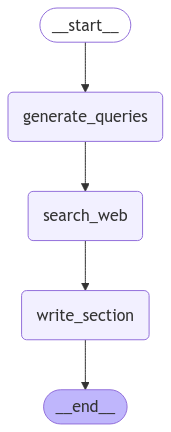

In [ ]:
# Display the graph
from IPython.display import display, Image
Image(section_builder_subagent.get_graph().draw_mermaid_png())

### Create Dynamic Parallelization Node Function - Parallelize Section Writing

`Send(...)` is used to parallelize and call the `section_builder_subagent` once for each section to write up the content (in parallel)

In [ ]:
from langgraph.constants import Send

def parallelize_section_writing(state: ReportState):
    """ This is the "map" step when we kick off web research for some sections of the report in parallel and then write the section"""

    # Kick off section writing in parallel via Send() API for any sections that require research
    return [
        Send("section_builder_with_web_search", # name of the subagent node
             {"section": s})
            for s in state["sections"]
              if s.research
    ]

## Create Format Sections Node Function

This is basically the section where all the sections are formatted and combined together into one big document.

![](https://i.imgur.com/6e5ZWK4.png)

In [ ]:
def format_sections(sections: list[Section]) -> str:
    """ Format a list of report sections into a single text string """
    formatted_str = ""
    for idx, section in enumerate(sections, 1):
        formatted_str += f"""
{'='*60}
Section {idx}: {section.name}
{'='*60}
Description:
{section.description}
Requires Research:
{section.research}

Content:
{section.content if section.content else '[Not yet written]'}

"""
    return formatted_str


def format_completed_sections(state: ReportState):
    """ Gather completed sections from research and format them as context for writing the final sections """

    print('--- Formatting Completed Sections ---')

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = format_sections(completed_sections)

    print('--- Formatting Completed Sections is Done ---')

    return {"report_sections_from_research": completed_report_sections}


## Instruction Prompts for Final Section

There is one main instruction prompt:

- __FINAL_SECTION_WRITER_PROMPT:__ Constrains the LLM to generate and write the content for either the introduction OR conclusion using certain guidelines on style, structure, length, approach and the content of the already written sections are also sent.

In [ ]:
FINAL_SECTION_WRITER_PROMPT = """You are an expert technical writer crafting a section that synthesizes information from the rest of the report.

Title for the section:
{section_title}

Topic for this section:
{section_topic}

Available report content of already completed sections:
{context}

1. Section-Specific Approach:

For Introduction:
- Use # for report title (Markdown format)
- 50-100 word limit
- Write in simple and clear language
- Focus on the core motivation for the report in 1-2 paragraphs
- Use a clear narrative arc to introduce the report
- Include NO structural elements (no lists or tables)
- No sources section needed

For Conclusion/Summary:
- Use ## for section title (Markdown format)
- 100-150 word limit
- For comparative reports:
    * Must include a focused comparison table using Markdown table syntax
    * Table should distill insights from the report
    * Keep table entries clear and concise
- For non-comparative reports:
    * Only use ONE structural element IF it helps distill the points made in the report:
    * Either a focused table comparing items present in the report (using Markdown table syntax)
    * Or a short list using proper Markdown list syntax:
      - Use `*` or `-` for unordered lists
      - Use `1.` for ordered lists
      - Ensure proper indentation and spacing
- End with specific next steps or implications
- No sources section needed

3. Writing Approach:
- Use concrete details over general statements
- Make every word count
- Focus on your single most important point

4. Quality Checks:
- For introduction: 50-100 word limit, # for report title, no structural elements, no sources section
- For conclusion: 100-150 word limit, ## for section title, only ONE structural element at most, no sources section
- Markdown format
- Do not include word count or any preamble in your response
- If there are special characters in the text, such as the dollar symbol,
  ensure they are escaped properly for correct rendering e.g $25.5 should become \$25.5"""

## Create Write Final Sections Node Function

This function uses the instruction prompot FINAL_SECTION_WRITER_PROMPT mentioned above to write up the introduction and conclusion. This function will be executed in parallel using `Send(...)` below

![](https://i.imgur.com/pRv4PX8.png)

In [ ]:
def write_final_sections(state: SectionState):
    """ Write the final sections of the report, which do not require web search and use the completed sections as context"""

    # Get state
    section = state["section"]
    completed_report_sections = state["report_sections_from_research"]

    print('--- Writing Final Section: '+ section.name + ' ---')

    # Format system instructions
    system_instructions = FINAL_SECTION_WRITER_PROMPT.format(section_title=section.name,
                                                             section_topic=section.description,
                                                             context=completed_report_sections)

    # Generate section
    user_instruction = "Craft a report section based on the provided sources."
    section_content = llm.invoke([SystemMessage(content=system_instructions),
                                  HumanMessage(content=user_instruction)])

    # Write content to section
    section.content = section_content.content

    print('--- Writing Final Section: '+ section.name + ' Completed ---')

    # Write the updated section to completed sections
    return {"completed_sections": [section]}

### Create Dynamic Parallelization Node Function - Parallelize Final Section Writing

`Send(...)` is used to parallelize and call the `write_final_sections` once for each of the introduction and conclusion to write up the content (in parallel)

In [ ]:
from langgraph.constants import Send

def parallelize_final_section_writing(state: ReportState):
    """ Write any final sections using the Send API to parallelize the process """

    # Kick off section writing in parallel via Send() API for any sections that do not require research
    return [
        Send("write_final_sections",
             {"section": s, "report_sections_from_research": state["report_sections_from_research"]})
                 for s in state["sections"]
                    if not s.research
    ]

## Compile Final Report Node Function

This function combines all the sections of the report together and compiles it into the final report document

![](https://i.imgur.com/wLxCNZ5.png)

In [ ]:
def compile_final_report(state: ReportState):
    """ Compile the final report """

    # Get sections
    sections = state["sections"]
    completed_sections = {s.name: s.content for s in state["completed_sections"]}

    print('--- Compiling Final Report ---')

    # Update sections with completed content while maintaining original order
    for section in sections:
        section.content = completed_sections[section.name]

    # Compile final report
    all_sections = "\n\n".join([s.content for s in sections])
    # Escape unescaped $ symbols to display properly in Markdown
    formatted_sections = all_sections.replace("\\$", "TEMP_PLACEHOLDER")  # Temporarily mark already escaped $
    formatted_sections = formatted_sections.replace("$", "\\$")  # Escape all $
    formatted_sections = formatted_sections.replace("TEMP_PLACEHOLDER", "\\$")  # Restore originally escaped $

# Now escaped_sections contains the properly escaped Markdown text


    print('--- Compiling Final Report Done ---')

    return {"final_report": formatted_sections}


## Build our Report Writer Planning Agent

We now bring all the defined components and sub-agent together and build our planning agent

![](https://i.imgur.com/STSC73k.png)

In [ ]:
builder = StateGraph(ReportState, input=ReportStateInput, output=ReportStateOutput)

builder.add_node("generate_report_plan", generate_report_plan)
builder.add_node("section_builder_with_web_search", section_builder_subagent)
builder.add_node("format_completed_sections", format_completed_sections)
builder.add_node("write_final_sections", write_final_sections)
builder.add_node("compile_final_report", compile_final_report)

builder.add_edge(START, "generate_report_plan")
builder.add_conditional_edges("generate_report_plan",
                              parallelize_section_writing,
                              ["section_builder_with_web_search"])
builder.add_edge("section_builder_with_web_search", "format_completed_sections")
builder.add_conditional_edges("format_completed_sections",
                              parallelize_final_section_writing,
                              ["write_final_sections"])
builder.add_edge("write_final_sections", "compile_final_report")
builder.add_edge("compile_final_report", END)

reporter_agent = builder.compile()

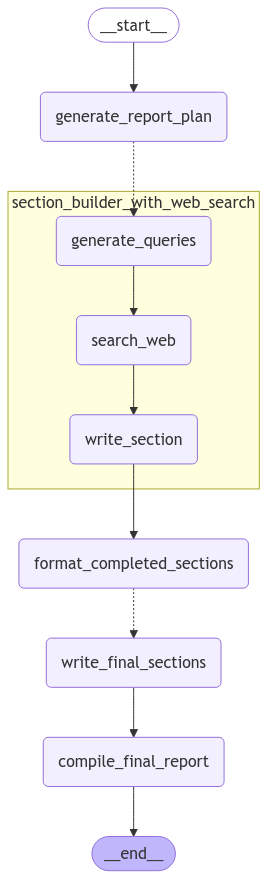

In [ ]:
display(Image(reporter_agent.get_graph(xray=True).draw_mermaid_png()))

## Run and Test our Agent

In [ ]:
from IPython.display import display
from rich.console import Console
from rich.markdown import Markdown as RichMarkdown

async def call_planner_agent(agent, prompt, config={"recursion_limit": 50}, verbose=False):
    events = agent.astream(
        {'topic' : prompt},
        config,
        stream_mode="values",
    )

    async for event in events:
        for k, v in event.items():
            if verbose:
                if k != "__end__":
                    display(RichMarkdown(repr(k) + ' -> ' + repr(v)))
            if k == 'final_report':
                print('='*50)
                print('Final Report:')
                md = RichMarkdown(v)
                display(md)

In [ ]:
topic = "Detailed report on how to build Agentic AI systems, design patterns and current frameworks"
await call_planner_agent(agent=reporter_agent,
                         prompt=topic)

--- Generating Report Plan ---
--- Generating Report Plan Completed ---
--- Generating Search Queries for Section: Foundational Architecture of Agentic AI ------ Generating Search Queries for Section: Design Principles for Agentic AI Systems ------ Generating Search Queries for Section: Agentic AI Design Patterns ---

--- Generating Search Queries for Section: Current Frameworks for Building Agentic AI ---

--- Generating Search Queries for Section: Real-World Applications and Case Studies ---
--- Generating Search Queries for Section: Challenges and Future Directions ---
--- Generating Search Queries for Section: Agentic AI Design Patterns Completed ---
--- Searching Web for Queries ---
--- Generating Search Queries for Section: Foundational Architecture of Agentic AI Completed ---
--- Searching Web for Queries ---
--- Generating Search Queries for Section: Current Frameworks for Building Agentic AI Completed ---
--- Searching Web for Queries ---
--- Generating Search Queries for Sect

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                                                  Introduction                                                   ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛

Agentic AI systems represent a significant evolution in artificial intelligence, transitioning from traditional    
models to autonomous agents capable of complex decision-making. These systems are designed to operate              
independently, adapting to dynamic environments without constant human oversight. Unlike traditional AI, which     
often requires human intervention, Agentic AI systems prioritize autonomy, adaptability, and collaboration,        
enabling them to perceive, reason, and act towards specific goals. This shift is transforming industries by        
enhancing operational efficiency and enabling complex task execution across various domains, such as healthcare,   
finance, and logistics. As Agentic AI continues to evolve, it promises to drive innovation and efficiency,         
reshaping the future of technology and its applications.                                                           


                                      Foundational Architecture of Agentic AI                                      

Agentic AI systems are revolutionizing autonomous decision-making by integrating core components like memory,      
tools, and planning mechanisms. These systems are designed to operate independently, adapting to dynamic           
environments without constant human oversight. A key example is the use of agentic AI in autonomous vehicles, where
AI processes real-time data from sensors to navigate and make decisions, enhancing safety and efficiency (Source:  
Daffodil).                                                                                                         

Agentic AI's architecture typically includes several layers: a knowledge foundation, an intelligence layer, and an 
action layer. The knowledge foundation uses real-time data retrieval to update its knowledge base, while the       
intelligence layer employs planning engines to break down complex tasks into manageable steps. The action layer    
executes decisions through APIs and service connections, ensuring seamless integration with business systems       
(Source: Microsoft Community Hub).                                                                                 

These systems are not only transforming industries like healthcare and finance but also enhancing operational      
efficiency in logistics and customer service. For instance, in healthcare, agentic AI assists in diagnostics and   
treatment planning by analyzing patient data and providing real-time insights (Source: AIMultiple).                

                                                      Sources                                                      

 • Daffodil: https://insights.daffodilsw.com/blog/top-20-agentic-ai-use-cases-in-the-real-world                    
 • Microsoft Community Hub:                                                                                        
   https://techcommunity.microsoft.com/blog/machinelearningblog/baseline-agentic-ai-systems-architecture/4207137   
 • AIMultiple: https://research.aimultiple.com/agentic-ai/                                                         


                                     Design Principles for Agentic AI Systems                                      

Agentic AI systems must prioritize autonomy, adaptability, and collaboration to effectively operate in dynamic     
environments. These systems, unlike traditional AI, are designed to independently perceive, reason, and act towards
specific goals. For instance, autonomous vehicles utilize Agentic AI to navigate complex traffic scenarios without 
human intervention, showcasing the system's a

In [ ]:
topic = "Detailed report on how is NVIDIA winning the game against its competitors"
await call_planner_agent(agent=reporter_agent,
                         prompt=topic)

--- Generating Report Plan ---
--- Generating Report Plan Completed ---
--- Generating Search Queries for Section: NVIDIA's Market Dominance in GPUs ------ Generating Search Queries for Section: Strategic Acquisitions and Partnerships ---
--- Generating Search Queries for Section: Technological Innovations and AI Leadership ---

--- Generating Search Queries for Section: Financial Performance and Growth Strategy ---
--- Generating Search Queries for Section: NVIDIA's Market Dominance in GPUs Completed ---
--- Searching Web for Queries ---
--- Generating Search Queries for Section: Financial Performance and Growth Strategy Completed ---
--- Searching Web for Queries ---
--- Generating Search Queries for Section: Technological Innovations and AI Leadership Completed ---
--- Searching Web for Queries ---
--- Generating Search Queries for Section: Strategic Acquisitions and Partnerships Completed ---
--- Searching Web for Queries ---
--- Searching Web for Queries Completed ---
--- Writing 

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                                                  Introduction                                                   ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛

NVIDIA stands as a formidable leader in the technology market, particularly in the GPU and AI sectors. With an     
impressive 90% market share in the discrete GPU market, NVIDIA has outpaced competitors like AMD and Intel through 
technological innovation and strategic positioning. The company's strategic acquisitions, such as Mellanox         
Technologies and Arm Limited, have bolstered its capabilities in AI and data centers, further solidifying its      
dominance. NVIDIA's advancements in AI and accelerated computing, coupled with robust financial performance,       
underscore its pivotal role in shaping the future of technology. This report will delve into how NVIDIA continues  
to outperform its competitors, setting new standards in the industry.                                              


                                         NVIDIA's Market Dominance in GPUs                                         

NVIDIA commands an unprecedented 90% of the global GPU market share as of Q3 2024, leaving competitors AMD and     
Intel far behind. This dominance is attributed to NVIDIA's strategic advancements and the anticipated release of   
the RTX 50 series. According to Jon Peddie Research, NVIDIA's market share surged from 84% in early 2024 to 90% by 
Q3, while AMD's share dwindled to 10%, and Intel's presence nearly vanished.                                       

Several factors contribute to NVIDIA's market leadership:                                                          

 • Technological Innovation: The RTX 50 series, featuring advanced AI capabilities and enhanced ray tracing, has   
   generated significant consumer interest.                                                                        
 • Strategic Positioning: NVIDIA's focus on AI and data center solutions has expanded its market reach, with AI GPU
   market shares estimated between 70% and 95%.                                                                    
 • Manufacturing Prowess: NVIDIA's robust manufacturing capabilities have outpaced competitors, allowing for rapid 
   deployment of new technologies.                                                                                 

Despite a 7.9% decline in overall GPU shipments year-over-year, NVIDIA's strategic initiatives have solidified its 
position as the leading force in the GPU sector, raising questions about innovation and pricing in a               
near-monopolistic market.                                                                                          

                                                      Sources                                                      

 • NVIDIA Crushes Rivals: Secures Unprecedented 90% of GPU Market in Q3 2024:                                      
   https://finance.yahoo.com/news/nvidia-crushes-rivals-secures-unprecedented-102235255.html                       
 • Nvidia's desktop GPU dominance grows to 88% as market returns to normal:                                        
   https://www.techspot.com/news/103293-nvidia-desktop-gpu-market-dominance-grows-88-sector.html                   
 • Nvidia AI GPU Market Share 2024: Unrivaled Dominance and Market Trends:                                         
   https://deepai.tn/papers/nvidia-ai-gpu-market-share-2024/                                                       


                                      Strategic Acquisitions and Partnerships                                      

NVIDIA's acquisition of Mellanox Technologies and Arm Limited has significantly enhanced its AI and data center    
capabilities. The $7 billion acquisition of 

In [ ]:
topic = "Detailed report on how DeepSeek has disrupted the AI Market"
await call_planner_agent(agent=reporter_agent,
                         prompt=topic)

--- Generating Report Plan ---
--- Generating Report Plan Completed ---
--- Generating Search Queries for Section: DeepSeek's Technological Innovations ---
--- Generating Search Queries for Section: Market Disruption and Economic Impact ---
--- Generating Search Queries for Section: Comparison with Established AI Models ---
--- Generating Search Queries for Section: Challenges and Criticisms ---
--- Generating Search Queries for Section: Comparison with Established AI Models Completed ---
--- Searching Web for Queries ---
--- Generating Search Queries for Section: Challenges and Criticisms Completed ---
--- Searching Web for Queries ---
--- Generating Search Queries for Section: Market Disruption and Economic Impact Completed ---
--- Searching Web for Queries ---
--- Generating Search Queries for Section: DeepSeek's Technological Innovations Completed ---
--- Searching Web for Queries ---
--- Searching Web for Queries Completed ---
--- Writing Section : DeepSeek's Technological Innovat

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                                                  Introduction                                                   ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛

DeepSeek is a groundbreaking player in the AI market, known for its innovative technological advancements and      
disruptive economic strategies. By leveraging open-source models and efficient AI development techniques, DeepSeek 
has redefined the landscape of AI model efficiency and accessibility. Its introduction of cost-effective models has
sparked significant price wars, challenging established tech giants like Nvidia and OpenAI. This report delves into
DeepSeek's technological innovations, market impact, and the challenges it faces, offering a comprehensive analysis
of its role in reshaping the AI industry.                                                                          


                                       DeepSeek's Technological Innovations                                        

DeepSeek's innovative use of the Mixture-of-Experts (MoE) architecture and efficient AI development techniques has 
redefined AI model efficiency. The DeepSeek-V3 model, launched in December 2024, exemplifies this with its 671     
billion parameters, yet only 37 billion are activated per task, significantly reducing computational costs. This   
model was trained using just 2,048 Nvidia H800 GPUs over two months, costing approximately $5.6 million, a fraction
of the cost for similar models from major tech companies.                                                          

DeepSeek's approach includes several key innovations:                                                              

 • Multi-Head Latent Attention (MLA): Enhances the model's ability to process complex inputs by focusing on        
   different data aspects simultaneously.                                                                          
 • FP8 Mixed Precision Training: Reduces memory usage and accelerates training without sacrificing accuracy.       
 • Auxiliary-Loss-Free Load Balancing: Ensures efficient distribution of computational tasks across the model's    
   parameters.                                                                                                     

These advancements allow DeepSeek to deliver high performance on benchmarks like MMLU-Pro and MATH 500, often      
surpassing models like GPT-4o. DeepSeek's commitment to open-source models democratizes access to advanced AI,     
challenging the dominance of established players and reshaping the AI landscape.                                   

                                                      Sources                                                      

 • All About DeepSeek — The Chinese AI Startup Challenging US Big Tech:                                            
   https://www.forbes.com/sites/janakirammsv/2025/01/26/all-about-deepseekthe-chinese-ai-startup-challenging-the-us
   -big-tech/                                                                                                      
 • Exploring DeepSeek-V3: A Technical Overview:                                                                    
   https://medium.com/@lmpo/exploring-deepseek-version-3-a-technical-deep-dive-0b3d2c78b777                        
 • DeepSeek: What you need to know about the AI that dethroned ChatGPT:                                            
   https://www.digitaltrends.com/computing/what-is-deepseek-everything-you-need-to-know/                           


                                       Market Disruption and Economic Impact                                       

DeepSeek's aggressive pricing strategy has triggered a significant price war in the AI market, challenging major   
players like Nvidia and OpenAI. The introduc